In [1]:
#imports 
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


In [2]:
### Set-up - Define file location
filename = 'N-CMAPSS_DS02-006.h5'

In [214]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.03319486666666762

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [4]:
#add index columns to help in restructuring
X_c=np.concatenate((A[:,:2],X_s,X_v),axis=1)

Text(0.5, 1.0, 'HPT_efficiency')

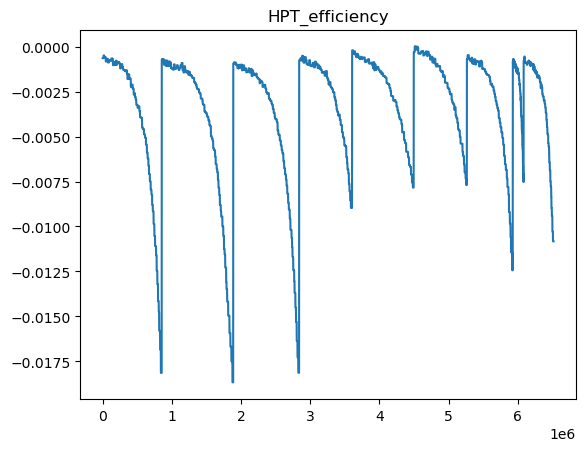

In [7]:
plt.plot(T[:,6])
plt.title('HPT_efficiency')

Text(0.5, 1.0, 'LPT_eff_mod')

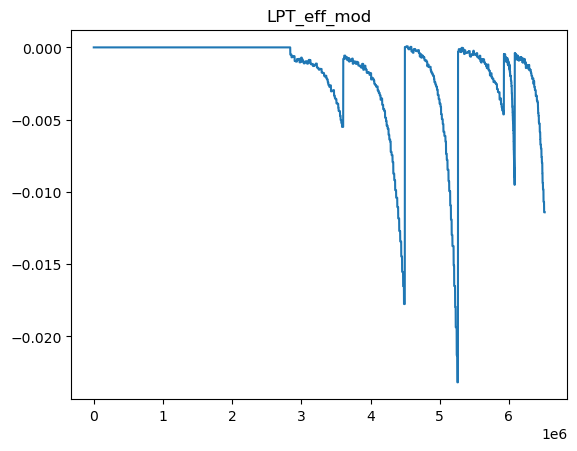

In [8]:
plt.plot(T[:,8])
plt.title(str(T_var[8]))

In [9]:
from sklearn.preprocessing import MinMaxScaler
lpt_sc=MinMaxScaler().fit_transform(T[:,8].reshape(-1,1))

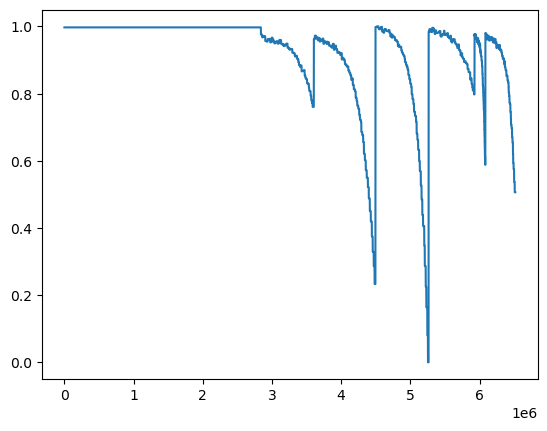

In [10]:
plt.plot(lpt_sc)

In [215]:
#let's try a 3D output layer - RUL, HPT eff, LPT eff. 
#this gives us 3 metrics for system health
#beware we should scale LPT/HPT to 0-1 as they are otherwise tiny scale
#we'll modify the reshape function to get a 3D y
#approach 3: sliding window across all flights and units, #kernel samples from each flight
def reshape_3D(arr,HPT,LPT,kernel,window): #recall this was built with X_c in mind!!
    #data points are sliding windows size w
    #first grab number of flights
    f=0
    for i in np.unique(arr[:,0]):
        dub=arr[arr[:,0]==i]
        f+=np.max(dub[:,1])
    trim=arr[:,2:] #get rid of indices
    k=trim.shape[1] #only after you've deleted unnecessary features!!!;
    X=np.zeros((int(kernel*f),window,6))
    y=np.zeros((int(kernel*f),2))
    t_ticker=0
    from sklearn.preprocessing import MinMaxScaler
    #here scaling hpt and lpt to then place as targets 
    hpt_sc=MinMaxScaler().fit_transform(HPT.reshape(-1,1))
    lpt_sc=MinMaxScaler().fit_transform(LPT.reshape(-1,1)) #note we need HPT and LPT to be the column specifically!
    unit_adder=0
    flight_adder=0
    indexer=[2,4,6,13,17,28]
    for i,n in enumerate(np.unique(arr[:,0])):
        dub=arr[arr[:,0]==n] #unit
        flight_adder=0
        for j in np.unique(dub[:,1]):
            bub=dub[dub[:,1]==j] #flight
            sub=MinMaxScaler().fit_transform(bub)
            #sub=dub[dub[:,1]==j]
            #t_tocker=0
            t_tocker=int(len(sub)//2-kernel//2)
            for k in range(kernel):
                rub=sub[t_tocker:(t_tocker+window),:]
                X[t_ticker,:,:]+=rub[:,indexer] #should be dim (window,k)
                y[t_ticker,0]+=len(sub)-(t_tocker+window)
                #we want the HPT and LPT values to be those from the following timestamp of the strap
                #within the flight, timestamp [t_tocker+window+1]
                #so 
                y[t_ticker,1]+=hpt_sc[unit_adder+flight_adder+k]-hpt_sc[unit_adder+flight_adder+k-window]
                #y[t_ticker,2]+=lpt_sc[unit_adder+flight_adder+t_tocker+window+1]
                t_ticker+=1
                t_tocker+=1
            flight_adder+=len(sub)
        unit_adder+=len(dub)
    return X,y

In [216]:
X_tr,y_tr=reshape_3D(arr=X_c,HPT=T[:,6],LPT=T[:,8],kernel=300,window=30)

In [5]:
#targets look proper and scaled
#let's build the model
#imports for LSTM
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError,R2Score
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.models import load_model

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [129]:
a=np.arange(len(X_tr))
tr_ind=np.random.randint(0,len(X_tr),int(0.8*len(X_tr)))
te_ind=np.delete(a,tr_ind)
#X_train=X_tr[tr_ind]
#y_train=y_tr[tr_ind]
X_test=X_tr[te_ind]
y_test=y_tr[te_ind]

In [217]:
X_train=X_tr
y_train=MinMaxScaler().fit_transform(y_tr.reshape(-1,1))

In [218]:
#construct RNN
model=Sequential() #each xi is run of n timestamps and we are targeting RUL for each 
model.add(LSTM(100,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2]))) #input layer
model.add(LSTM(100,return_sequences=False)) #hidden layer
model.add(Dense(100,'relu')) #activation function
model.add(Dense(2,'linear')) #output
cp=ModelCheckpoint('modelnew.h5',save_best_only=True) #to save the best model
model.compile(loss='MeanSquaredError',optimizer=Adam(learning_rate=0.01),metrics=['MeanAbsoluteError']) #set the loss function optimizer and metric
model.fit(X_train,y_train,validation_split=0.3,epochs=10,callbacks=[cp]) #fit the model
model=load_model('modelnew.h5')



Epoch 1/10
1230/4253 [=======>......................] - ETA: 59s - loss: 0.1124 - mean_absolute_error: 0.3157 

KeyboardInterrupt: 

In [68]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 30, 100)           42800     
                                                                 
 lstm_25 (LSTM)              (None, 100)               80400     
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 2)                 202       
                                                                 
Total params: 133502 (521.49 KB)
Trainable params: 133502 (521.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [221]:
#seems like there are issues with targets of different shape
#let's try just targeting HPT and then extend to HPT-LPT
def reshape_3D(arr,HPT,LPT,kernel,window): #recall this was built with X_c in mind!!
    #data points are sliding windows size w
    #first grab number of flights
    f=0
    for i in np.unique(arr[:,0]):
        dub=arr[arr[:,0]==i]
        f+=np.max(dub[:,1])
    div=10
    trim=arr[:,2:] #get rid of indices
    k=trim.shape[1] #only after you've deleted unnecessary features!!!;
    X=np.zeros((int(kernel*f//div),window,6))
    y=np.zeros((int(kernel*f//div),))
    t_ticker=0
    from sklearn.preprocessing import MinMaxScaler
    #here scaling hpt and lpt to then place as targets 
    hpt_sc=MinMaxScaler().fit_transform(HPT.reshape(-1,1))
    lpt_sc=MinMaxScaler().fit_transform(LPT.reshape(-1,1)) #note we need HPT and LPT to be the column specifically!
    unit_adder=0
    flight_adder=0
    indexer=[2,4,6,13,17,28]
    for i,n in enumerate(np.unique(arr[:,0])):
        dub=arr[arr[:,0]==n] #unit
        flight_adder=0
        for j in np.unique(dub[:,1]):
            bub=dub[dub[:,1]==j] #flight
            sub=MinMaxScaler().fit_transform(bub)
            #sub=dub[dub[:,1]==j]
            #t_tocker=0
            t_tocker=int(len(sub)//2-kernel//2)
            for k in np.linspace(0,kernel,kernel//div).astype(int):
                rub=sub[t_tocker:(t_tocker+window),:]
                X[t_ticker,:,:]+=rub[:,indexer] #should be dim (window,k)
                #y[t_ticker,0]+=len(sub)-(t_tocker+window)
                #we want the HPT and LPT values to be those from the following timestamp of the strap
                #within the flight, timestamp [t_tocker+window+1]
                #just HPT as the target this time
                y[t_ticker]+=HPT[unit_adder+flight_adder+k]-HPT[unit_adder+flight_adder+k-window]
                #y[t_ticker,2]+=lpt_sc[unit_adder+flight_adder+t_tocker+window+1]
                t_ticker+=1
                t_tocker+=1
            flight_adder+=len(sub)
        unit_adder+=len(dub)
    return X,y

In [222]:
X_tr,y_tr=reshape_3D(arr=X_c[X_c[:,0]==2.0],HPT=T[:,6],LPT=T[:,8],kernel=1000,window=500)

In [227]:
y_2=T[X_c[:,0]==2.0,6]
y_tr[:50]=y_tr[:50]-0.010

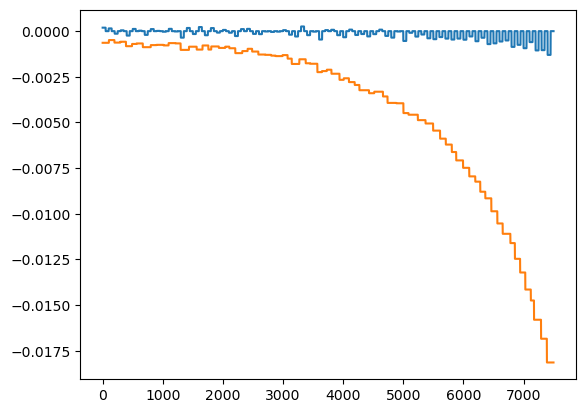

In [229]:
plt.plot(y_tr)
plt.plot(y_2[np.linspace(0,len(y_2),len(y_tr)).astype(int)[:-1]])

In [257]:
a=np.arange(len(X_tr))
tr_ind=np.random.randint(0,len(X_tr),int(0.8*len(X_tr)))
te_ind=np.delete(a,tr_ind)
#X_train=X_tr[tr_ind]
#y_train=y_tr[tr_ind]
X_test=X_tr[te_ind]
y_test=y_tr[te_ind]

In [258]:
X_tr.shape

(7500, 500, 6)

In [259]:
y_tr.shape

(7500,)

In [230]:
X_train=X_tr
y_train=MinMaxScaler().fit_transform(y_tr.reshape(-1,1))

In [231]:
#construct RNN
model_hpt=Sequential() #each xi is run of n timestamps and we are targeting RUL for each 
model_hpt.add(LSTM(100,return_sequences=True,input_shape=(X_tr.shape[1],X_tr.shape[2]))) #input layer
model_hpt.add(LSTM(100,return_sequences=False)) #hidden layer
model_hpt.add(Dense(50,'tanh')) #activation function
model_hpt.add(Dense(1,'linear')) #output
cp=ModelCheckpoint('modelhpt.h5',save_best_only=True) #to save the best model
model_hpt.compile(loss='MeanAbsoluteError',optimizer=Adam(learning_rate=0.01),metrics=['R2Score']) #set the loss function optimizer and metric
model_hpt.fit(X_tr,y_tr,validation_split=0.3,epochs=20,callbacks=[cp]) #fit the model
model_hpt=load_model('modelhpt.h5')

#X and y appear to be what I want them to be, scaled, matching.
#something about the setup of this model?
#worth a deep dive into the architecture


Epoch 1/20
165/165 [==============================] - 62s 360ms/step - loss: 0.0359 - r2_score: -3079864.2500 - val_loss: 0.0066 - val_r2_score: -344.1711
Epoch 2/20


/Users/alexanderbeyer/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


165/165 [==============================] - 58s 354ms/step - loss: 0.0025 - r2_score: -542.1428 - val_loss: 0.0042 - val_r2_score: -135.1470
Epoch 3/20
165/165 [==============================] - 60s 363ms/step - loss: 0.0014 - r2_score: -140.9146 - val_loss: 0.0019 - val_r2_score: -27.2380
Epoch 4/20
165/165 [==============================] - 60s 365ms/step - loss: 0.0016 - r2_score: -179.0152 - val_loss: 0.0014 - val_r2_score: -16.3875
Epoch 5/20
165/165 [==============================] - 59s 359ms/step - loss: 0.0013 - r2_score: -100.3178 - val_loss: 5.0184e-04 - val_r2_score: -1.4839
Epoch 6/20
165/165 [==============================] - 59s 355ms/step - loss: 0.0011 - r2_score: -68.9146 - val_loss: 0.0012 - val_r2_score: -10.8016
Epoch 7/20
165/165 [==============================] - 58s 351ms/step - loss: 9.7408e-04 - r2_score: -73.5733 - val_loss: 3.0037e-04 - val_r2_score: -0.2300
Epoch 8/20
 87/165 [==============>...............] - ETA: 24s - loss: 9.9757e-04 - r2_score: -69.0160

KeyboardInterrupt: 

In [262]:
#this one appeared to get stuck in a local minimum. 0.16 MAE is not good
preds=model_hpt.predict(X_tr)

235/235 [==============================] - 24s 98ms/step


In [209]:
#seems like there are issues with targets of different shape
#let's try just targeting HPT and then extend to HPT-LPT
def reshape_flights(arr,minlength,window): #recall this was built with X_c in mind!!
    #data points are sliding windows size w
    #first grab number of flights
    f=9*(minlength-window)
    trim=arr[:,2:] #get rid of indices
    k=trim.shape[1] #only after you've deleted unnecessary features!!!;
    X=np.zeros((f,window,k)) #now n is number of flights
    t_ticker=0
    from sklearn.preprocessing import MinMaxScaler
    #here scaling hpt and lpt to then place as targets 
    indexer=[2,4,6,13,17,28]
    for i,n in enumerate(np.unique(arr[:,0])):
        dub=arr[arr[:,0]==n] #unit
        dub=dub[dub[:,1]<minlength]
        means_arr=np.zeros((minlength,k))
        for j in np.unique(dub[:,1]):
            bub=dub[dub[:,1]==j] #flight
            sub=MinMaxScaler().fit_transform(bub) #scaled features
            means_arr[int(j)]+=np.mean(sub[:,2:],axis=0) #feature means for the flight
        for w in range(minlength-window):
            X[t_ticker,:,:]+=means_arr[w:(w+window)]
            #sub=dub[dub[:,1]==j]
            #t_tocker=0
            #t_tocker=int(len(sub)//2-kernel//2)
        
            t_ticker+=1    
    return X

In [210]:
X_t=reshape_flights(X_c,minlength=59,window=35)
X_t=X_t[9:]

In [64]:
from sklearn.preprocessing import MinMaxScaler

In [205]:
X_c_t=np.concatenate((X_c,T),axis=1)
l=[]
minlength=59
window=35
for i in np.unique(X_c_t[:,0]):
    dub=X_c_t[X_c_t[:,0]==i]
    for j in np.unique(dub[:,1]):
        if j<minlength-window:
            sub=dub[dub[:,1]==j]
            l.append(np.mean(sub[:,36]))
        else:
            continue
y=np.array(l)
y=MinMaxScaler().fit_transform(y.reshape(-1,1))

In [211]:
#construct RNN
model_hpt=Sequential() #each xi is run of n timestamps and we are targeting RUL for each 
model_hpt.add(LSTM(100,return_sequences=True,input_shape=(X_t.shape[1],X_t.shape[2]))) #input layer
model_hpt.add(LSTM(100,return_sequences=True)) #hidden layer
model_hpt.add(LSTM(100,return_sequences=True)) #hidden layer
model_hpt.add(LSTM(100,return_sequences=False))
model_hpt.add(Dense(50,'relu')) #activation function
model_hpt.add(Dense(1,'linear')) #output
cp=ModelCheckpoint('modelhpt.h5',save_best_only=True) #to save the best model
model_hpt.compile(loss='MeanAbsoluteError',optimizer=Adam(learning_rate=0.001),metrics=['R2Score']) #set the loss function optimizer and metric
model_hpt.fit(X_t,y,validation_split=0.2,epochs=100,callbacks=[cp]) #fit the model
model_hpt=load_model('modelhpt.h5')

#X and y appear to be what I want them to be, scaled, matching.
#something about the setup of this model?
#worth a deep dive into the architecture


Epoch 1/100
6/6 [==============================] - 6s 153ms/step - loss: 0.2349 - r2_score: -2.6599 - val_loss: 0.5321 - val_r2_score: -10.2715
Epoch 2/100
2/6 [=========>....................] - ETA: 0s - loss: 0.2429 - r2_score: -1.8766

/Users/alexanderbeyer/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 59ms/step - loss: 0.1745 - r2_score: -1.0349 - val_loss: 0.2930 - val_r2_score: -3.0952
Epoch 3/100
6/6 [==============================] - 0s 48ms/step - loss: 0.1332 - r2_score: -0.1618 - val_loss: 0.2894 - val_r2_score: -3.0176
Epoch 4/100
6/6 [==============================] - 0s 46ms/step - loss: 0.1232 - r2_score: -0.0325 - val_loss: 0.3053 - val_r2_score: -3.3705
Epoch 5/100
6/6 [==============================] - 0s 49ms/step - loss: 0.1250 - r2_score: -0.0442 - val_loss: 0.2825 - val_r2_score: -2.8679
Epoch 6/100
6/6 [==============================] - 0s 49ms/step - loss: 0.1224 - r2_score: -0.0283 - val_loss: 0.2796 - val_r2_score: -2.8021
Epoch 7/100
6/6 [==============================] - 0s 46ms/step - loss: 0.1236 - r2_score: -0.0271 - val_loss: 0.2972 - val_r2_score: -3.1936
Epoch 8/100
6/6 [==============================] - 0s 46ms/step - loss: 0.1263 - r2_score: -0.0798 - val_loss: 0.3119 - val_r2_score: -3.5194
Epoch 9/100
6/6 [=

In [192]:
#now let's try just an evenly spaced sample
def reshape_sample(arr,HPT,sample,window): #recall this was built with X_c in mind!!
    trim=arr[:,] #get rid of indices
    k=trim.shape[1] #only after you've deleted unnecessary features!!!;
    #selector=[2,4,6,13,17,28]
    arr=arr[:,2:]
    X=np.zeros((sample-1,window,28))
    index=np.linspace(0,len(arr),sample).astype(int)[:-1]
    y=HPT[index]
    for i in range(len(index)-window):
        ind=index[i:(i+window)]
        X[i]+=arr[ind]
    return X,y

In [193]:
X_samp,y_samp=reshape_sample(X_c,T[:,6],10000,100)

In [186]:
X_samp.shape

(4999, 100, 6)

In [194]:
#construct RNN
model_smp=Sequential() #each xi is run of n timestamps and we are targeting RUL for each 
model_smp.add(LSTM(100,return_sequences=True,input_shape=(X_samp.shape[1],X_samp.shape[2]))) #input layer
model_smp.add(LSTM(100,return_sequences=True)) #hidden layer
model_smp.add(LSTM(100,return_sequences=False))
model_smp.add(Dense(50,'relu')) #activation function
model_smp.add(Dense(1,'linear')) #output
cp=ModelCheckpoint('modelhpt.h5',save_best_only=True) #to save the best model
model_smp.compile(loss='MeanAbsoluteError',optimizer=Adam(learning_rate=0.01),metrics=['R2Score']) #set the loss function optimizer and metric
model_smp.fit(X_samp,y_samp,validation_split=0.2,epochs=10,callbacks=[cp]) #fit the model
model_smp=load_model('modelhpt.h5')

#X and y appear to be what I want them to be, scaled, matching.
#something about the setup of this model?
#worth a deep dive into the architecture


Epoch 1/10
250/250 [==============================] - 29s 108ms/step - loss: 0.0325 - r2_score: -1456.2902 - val_loss: 0.0052 - val_r2_score: -3.1618
Epoch 2/10
  1/250 [..............................] - ETA: 23s - loss: 0.0046 - r2_score: -2.1933

/Users/alexanderbeyer/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 26s 104ms/step - loss: 0.0029 - r2_score: -0.2835 - val_loss: 0.0021 - val_r2_score: -0.3709
Epoch 3/10
218/250 [=========================>....] - ETA: 3s - loss: 0.0032 - r2_score: -0.5069

KeyboardInterrupt: 